In [ ]:
!pip install -r ../requirements.txt

In [1]:
import os
import numpy as np
import nltk
import pandas as pd
import json
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk import word_tokenize
import string
import json
import unidecode 
import re

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/kian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## --------------------------- Reading and Preprocessing data ---------------------------

In [10]:
from preprocessing.preprocessing import Preprocessor


class DataReader:
    def __init__(self, read_from_excels=False):
        if read_from_excels:
            preprocessor = Preprocessor()
            dfs = []
            for file in tqdm(os.listdir("./Excels")):
                df = pd.read_excel(os.path.join("./Excels", file))
                dfs.append(df)
            df = pd.concat(dfs)
            
            df = df[df['Language'] == 'en']
            df.reset_index(drop=True, inplace=True)
            df.drop_duplicates(subset="Text", keep='first', inplace=True, ignore_index=True)
            df = preprocessor.perform_clean_lemmatize_tokenize(df)
            idx = df.Text_words.apply(len) > df.Text_words.apply(len).describe()["25%"]
            df = df[idx]
            
            df["Text_words_joined"] = df.Text_words.apply(lambda x: " ".join(x))
            df.drop_duplicates(subset="Text_words_joined", keep='first', inplace=True, ignore_index=True)
            self.df = df
            
        else:
            df = pd.read_csv("./data_final.csv")
            df["Text_words"] = df.Text_words_joined.apply(lambda x: x.split(" "))
            df.drop("Unnamed: 0", axis=1, inplace=True)
            self.df = df

       
            
data_reader = DataReader(read_from_excels=False)
df = data_reader.df

In [11]:
df.head()

,Tweet Id,Text,cleaned_tweets,lemmatized_tweets,Text_words_joined,Text_words
0,1547201923266351106,RT @JonJonesSnr : Labour accuses No 10 of 'fla...,labour accuses flagrant abuse power refuses al...,labour accuse flagrant abuse power refuse allo...,labour accuse flagrant abuse power refuse allo...,"[labour, accuse, flagrant, abuse, power, refus..."
1,1547201914525421569,@DonaldJTrumpJr Unbelievable. Closing down the...,unbelievable closing debate saying opens trans...,unbelievable close debate say open trans peopl...,unbelievable close debate say open trans peopl...,"[unbelievable, close, debate, say, open, trans..."
2,1547201911853572096,Isn’t it funny how once the internet learned l...,funny internet learned logical fallacy termino...,funny internet learn logical fallacy terminolo...,funny internet learn logical fallacy terminolo...,"[funny, internet, learn, logical, fallacy, ter..."
3,1547201910670823426,"@MoeedNj You're right, Moeed. Political rhetor...",right moeed political rhetoric par excellence ...,right moeed political rhetoric par excellence ...,right moeed political rhetoric par excellence ...,"[right, moeed, political, rhetoric, par, excel..."
4,1547201898884878336,RT @BryanDBender : JUST IN: UFO amnesty provis...,ufo amnesty provision proposed order house rul...,ufo amnesty provision propose order house rule...,ufo amnesty provision propose order house rule...,"[ufo, amnesty, provision, propose, order, hous..."


In [4]:
df.Text_words.apply(len).describe()

count    26558.000000
mean        17.328338
std          5.834983
min          9.000000
25%         12.000000
50%         17.000000
75%         22.000000
max         49.000000
Name: Text_words, dtype: float64

In [5]:
df.Text_words.explode().value_counts().head(10)

get          2998
developer    2414
us           2377
new          2143
like         2049
people       2023
say          1985
go           1969
make         1917
war          1892
Name: Text_words, dtype: int64

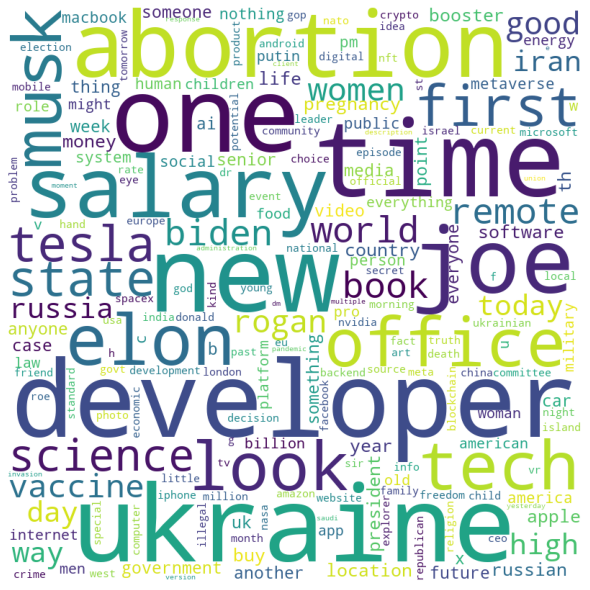

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join(set(df['Text_words'].explode()) - {np.nan})
all_words = " ".join(df['Text_words'].explode().value_counts().reset_index()['index'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [7]:
nltk.FreqDist(df['Text_words'].explode()).most_common(20)

[('get', 2998),
 ('developer', 2414),
 ('us', 2377),
 ('new', 2143),
 ('like', 2049),
 ('people', 2023),
 ('say', 1985),
 ('go', 1969),
 ('make', 1917),
 ('war', 1892),
 ('would', 1740),
 ('back', 1661),
 ('trump', 1653),
 ('work', 1609),
 ('one', 1590),
 ('ukraine', 1561),
 ('time', 1549),
 ('know', 1442),
 ('use', 1428),
 ('need', 1358)]

## TF-IDF Search ---------------------------

In [8]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFSearch:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})

        self.tfidf = TfidfVectorizer(vocabulary=self.vocabulary)
        self.tfidf_tran = self.tfidf.fit_transform(df['Text_words'].apply(lambda x: ' '.join(x)))

    def get_vector(self, tokens):
        result = np.zeros((len(self.vocabulary)))
        x = self.tfidf.transform(tokens)
        for token in tokens:
            try:
                ind = self.vocabulary.index(token)
                result[ind]  = x[0, self.tfidf.vocabulary_[token]]
            except Exception as e:
                print(e)
                pass
        return result

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = self.preprocessor.clean_query(query)
        tokens = [token for token in tokens if token in self.vocabulary]
        print(tokens)
        q_df = pd.DataFrame(columns=['q_clean'])
        q_df.loc[0, 'q_clean'] = tokens

        d_cosines = []

        query_vector = self.get_vector(tokens)
        print(sum(query_vector))
        for d in self.tfidf_tran.A:
            d_cosines.append(self.cosine_sim(query_vector, d))

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

In [9]:
model = TFIDFSearch()
results = model.search(10, "Elon Musk buying twitter")
results

[nltk_data] Downloading package stopwords to /Users/kian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['elon', 'musk', 'buy', 'twitter']
1.0


,index,text,words,Score
0,20025,RT @WayneSmithUK71 : @nytimes Elon Musk damage...,"['elon', 'musk', 'damage', 'trust', 'elon', 'm...",0.500485
1,11031,Twitter sues Elon Musk https://t.co/tnmcYXx1cD...,"['twitter', 'sue', 'elon', 'musk', 'elon', 'mu...",0.453855
2,26230,🔥👽 Episode 87 of Elon Musk Radio!\n\nTwitter: ...,"['episode', 'elon', 'musk', 'radio', 'twitter'...",0.453289
3,26054,"I believe elon is a measure of left and right,...","['believe', 'elon', 'measure', 'leave', 'right...",0.448867
4,20202,So Twitter wants to force Elon Musk to buy Twi...,"['twitter', 'want', 'force', 'elon', 'musk', '...",0.425154
5,7368,Elon has his trigger finger in the river. If h...,"['elon', 'trigger', 'finger', 'river', 'fall',...",0.417281
6,7319,@drmistercody My favorite part is the paging E...,"['favorite', 'part', 'page', 'elon', 'like', '...",0.414343
7,20188,@biggestjoel @elonmusk The irony is Twitter su...,"['irony', 'twitter', 'sue', 'elon', 'buy', 'tw...",0.393487
8,7366,@Blockworks_ Some one phone Elon @elonmusk pur...,"['one', 'phone', 'elon', 'purchase', 'btc', 'm...",0.392115
9,7459,@20W24 I don’t listen to Elon Musk… I’m conser...,"['listen', 'elon', 'musk', 'conservative', 'el...",0.379351


## Boolean Search ---------------------------

In [64]:
class BooleanSearch:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})
        self.vocabulary_index = {word: idx for idx, word in enumerate(self.vocabulary)}
        self.mat = np.zeros((len(df), len(self.vocabulary)), )
        for index, row in df.iterrows():
            for token in row['Text_words']:
                self.mat[index][self.vocabulary_index[token]] = 1


    def search(self, k, query):
        tokens = self.preprocessor.clean_query(query)
        query_vector = []
        for token in tokens:
            if token in self.vocabulary_index:
                query_vector.append(self.vocabulary_index[token])
        out = []
        for index, vec in enumerate(self.mat):
            flag = True
            for token_index in query_vector:
                if vec[token_index] == 0:
                    flag = False
                    break
            if flag:
                out.append(index)
            if len(out) == k:
                break
        print(out)
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])

        return a

In [65]:
model = BooleanSearch()
model.search(10, "Elon Musk buying twitter")

[nltk_data] Downloading package stopwords to /Users/kian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[7303, 7363, 7369, 7385, 7474, 7526, 7573, 10483, 10761, 10895]


,index,text,words
0,7303,RT @conspiracyb0t : China buying up massive amounts of land in America should be way more concerning than Elon Musk trying to buy Twitter.,"['china', 'buy', 'massive', 'amount', 'land', 'america', 'way', 'concern', 'elon', 'musk', 'try', 'buy', 'twitter']"
1,7363,RT @MattWallace888 : Rumors are spreading that Elon Musk is going to buy twitter faster than expected,"['rumor', 'spread', 'elon', 'musk', 'go', 'buy', 'twitter', 'faster', 'expect']"
2,7369,RT @jimmyfailla : Elon Musk is buying Twitter and everyone freaking out drives a Tesla. There’s never been a dumber time to be alive.,"['elon', 'musk', 'buy', 'twitter', 'everyone', 'freak', 'drive', 'tesla', 'never', 'dumber', 'time', 'alive']"
3,7385,"RT @Sana_f2 : #IndiaSuppressingSpeech\nWith Elon Musk striking a deal to buy Twitter, an age-old debate around free speech has emerged once again....","['elon', 'musk', 'strike', 'deal', 'buy', 'twitter', 'ageold', 'debate', 'around', 'free', 'speech', 'emerge', 'musk', 'call', 'free', 'speech', '..."
4,7474,"@destroyed4com4t @elonmusk I don't think they fully comprehend, that Elon Musk hasn't actually bought twitter yet &amp; he's actively trying to ba...","['think', 'fully', 'comprehend', 'elon', 'musk', 'actually', 'buy', 'twitter', 'yet', 'actively', 'try', 'back', 'pay', 'want', 'admit', 'already'..."
5,7526,RT @BritishGQ : Elon Musk is going to be sorry he agreed to buy Twitter when he sees this post and reads about how good the Hyundai IONIQ 5 really...,"['elon', 'musk', 'go', 'sorry', 'agree', 'buy', 'twitter', 'see', 'post', 'read', 'good', 'hyundai', 'ioniq', 'really']"
6,7573,scenes when elon musk buys twitter and my 4 banned accounts come back,"['scenes', 'elon', 'musk', 'buy', 'twitter', 'ban', 'account', 'come', 'back']"
7,10483,Twitter Sues Tesla CEO Elon Musk for Not buying the social media platform.\n\nhttps://t.co/OUbuZ7ttgD\n\n#twitter #TwitterDeal #ElonMusk #elonmusk...,"['twitter', 'sue', 'tesla', 'ceo', 'elon', 'musk', 'buy', 'social', 'media', 'platform']"
8,10761,"RT @SAfmnews : Twitter has fired back at Elon Musk, accusing the world's richest person of ""knowingly"" breaching an agreement to buy the social me...","['twitter', 'fire', 'back', 'elon', 'musk', 'accuse', 'worlds', 'richest', 'person', 'knowingly', 'breach', 'agreement', 'buy', 'social', 'media',..."
9,10895,"Twitter Sues Tesla CEO! Elon Musk Says, ‘Oh the Irony’ - https://t.co/G8GcmhdES6\n\nTwitter Inc. has filed a lawsuit against Elon Musk for breakin...","['twitter', 'sue', 'tesla', 'ceo', 'elon', 'musk', 'say', 'oh', 'irony', 'twitter', 'inc', 'file', 'lawsuit', 'elon', 'musk', 'break', 'term', 'bi..."


## FastText ---------------------------

In [31]:
import fasttext.util

class FastText:
    def __init__(self):
        self.preprocessor = Preprocessor()        
        fasttext.util.download_model('en', if_exists='ignore')  # English
        self.ft = fasttext.load_model("./cc.en.300.bin")
        
        self.text_vectors = []
        self.words_count = []
        for _, row in df.iterrows():
            self.words_count.append(len(row['Text_words']))
            self.text_vectors.append(self.tokens_to_vec(row['Text_words']))

    def tokens_to_vec(self, tokens):
        cur_vectors = []
        if len(tokens) == 0:
            return np.zeros(self.ft.get_dimension())
        for token in tokens:
            cur_vectors.append(self.ft.get_word_vector(token))
        return np.asarray(np.average(cur_vectors, axis=0, keepdims=True))[0]

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = self.preprocessor.clean_query(query)
        query_vector = self.tokens_to_vec(tokens)
        d_cosines = []
        print(tokens)
        for idx, d in enumerate(self.text_vectors):
            d_cosines.append(self.cosine_sim(d, query_vector))
            if self.words_count[idx] > 10:
                d_cosines[-1] += 0.2
            elif self.words_count[idx] > 5:
                d_cosines[-1] += 0.1

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

In [34]:
# model = FastText()
# model.search(10, "Elon Musk buying twitter")

In [32]:
pd.set_option('display.max_colwidth', 150)

## Transformer ---------------------------

In [ ]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

class TransformerSearch:
    def __init__(self, df):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.preprocessor = Preprocessor()

        self.all_embeddings = []
        for tweet in tqdm(df.Text_words):
            joined_tweet = " ".join(tweet)
            tweet_embedding = self.model.encode(joined_tweet)
            self.all_embeddings.append(tweet_embedding)

        # with open('/content/gdrive/MyDrive/MIR-HW3-Transformer/all_embeddings.npy', 'wb') as f:
        #     np.save(f, self.all_embeddings)

        # self.all_embeddings = np.load("/content/gdrive/MyDrive/MIR-HW3-Transformer/all_embeddings.npy")

    def search(self, k, query):
        cleaned = self.preprocessor.clean_query(query)
        cleaned = ' '.join(cleaned)

        encoded_q = self.model.encode([cleaned])

        scores = np.array([(1-cosine(doc, encoded_q)) for doc in self.all_embeddings])
        tops = scores.argsort()[-k:][::-1]
        print(tops)


        a = pd.DataFrame()
        for i, index in enumerate(tops):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = scores[int(index)]
        return a

In [66]:
# model = TransformerSearch()
# model.search(10, "Elon Musk buying twitter")

# ---------------------------- Evalutation ----------------------------

In [ ]:
models = [FastText(), BooleanSearch(), TFIDFSearch(), ]

In [14]:
class Evaluator:
    queries = [
        "how to became full stack developer",
        "Microsoft Internet Explorer age",
        "Tesla price",
        "Macbook M2 Price",
        "Abortion rights",
        "Ukraine war",
        "Raisi",
        "Harry potter",
        "Covid vaccine",
        "Meta VR"
    ]

    def run(self):
        scores = np.zeros((len(self.queries),len(models)))
        for idxq, query in enumerate(self.queries):
            for idxm, model in enumerate(models):
                result = model.search(10, query)
                for idxr, row in result.iterrows():
                    print("-"*100)
                    print(">", query)
                    print(row['text'])
                    if input("Are result related to query?(y/n)").lower() == 'y':
                        scores[idxq][idxm] = 1/(idxr + 1)
                        break
        self.scores = scores
evaluator = Evaluator()
evaluator.run()

['become', 'full', 'stack', 'developer']
----------------------------------------------------------------------------------------------------
> how to became full stack developer
@TreciaKS You are either a front end or full stack developer coz as a Backend developer I rarely get that urge 😁
Are result related to query?(y/n)n
----------------------------------------------------------------------------------------------------
> how to became full stack developer
RT @YuHelenYu : Roadmap to Full Stack Developer 
#AI #DataSecurity #dataScientist #DataAnalytics #RStats #Reactjs #IIoT #flutter #javascript #java #TensorFlow #Cloud #coding #BigData #5G #MachineLearning  #R #reddit #WomenInSTEM  #fintech #tech #blockchain #DataScience  #100DaysOfCode #Jobs https://t.co/o1ATvNKGn9
Are result related to query?(y/n)y
[5264]
----------------------------------------------------------------------------------------------------
> how to became full stack developer
Be job-ready with Ashwat School. Become

Are result related to query?(y/n)y
['macbook', 'price']
----------------------------------------------------------------------------------------------------
> Macbook M2 Price
And Now This:  Apple M2 iPad Pro series prices leaked along with details about more-responsive iPad mini and laminated iPad - https://t.co/zuY25fN6cg

#technology #tech #technews

Read More Here:
https://t.co/5LewoWNDke
Are result related to query?(y/n)y
[12731, 12938, 12971]
----------------------------------------------------------------------------------------------------
> Macbook M2 Price
C$34.2 - #FreeShipping | Amazing deals at amazing low prices  The Decal Guru Apple Sauce Shot MacBook Decal #TheDecalGuru       👉 https://t.co/CWRarWy6gX       #sharious  #canadianbestseller  #canada #usa #product #1268MAC13XDB  #2016  #Apple  #Decal . https://t.co/srtyxsiB0o
Are result related to query?(y/n)y
['macbook', 'price']
1.0
------------------------------------------------------------------------------------------

Are result related to query?(y/n)y
[7249, 7268, 7351, 7357, 7446, 7458, 7525, 7789, 8205, 11330]
----------------------------------------------------------------------------------------------------
> Meta VR
RT @quantum_input : Meta wants its next VR headset to replace your laptop https://t.co/x6Mf0r5ZNS #Meta #Vr
Are result related to query?(y/n)y
['meta', 'vr']
1.0
----------------------------------------------------------------------------------------------------
> Meta VR
Report: Meta to Release First AR Glasses to Developers Only &amp; Not Consumers #meta #ar #vr #edtech #edtechchat #edchat | @scoopit https://t.co/FXvg88aBxH
Are result related to query?(y/n)y


In [15]:
pd.DataFrame({
    "models": map(lambda x: x.__class__.__name__, models),
    "scores": evaluator.scores.mean(axis=0),
})

,models,scores
0,FastText,0.900000
1,BooleanSearch,0.850000
2,TFIDFSearch,0.766667
